In [1]:
text = []

with open('text8') as f:
    for line in f:
        text.append(line)
    text = ''.join(text)

vocab_size = len(set(text)) + 1
print(vocab_size)

28


In [2]:
EOS_id = 0

def char_to_id(char):
    if char == ' ':
        return 1
    else:
        return ord(char) - ord('a') + 2

def id_to_char(i):
    if i == 0:
        return ''
    elif i == 1:
        return ' '
    else:
        return chr(ord('a') + i - 2)
    
import numpy as np

text_ids = {'full': np.array(list(map(char_to_id, text)))}
print(text[:10])
print(text_ids['full'][:10])

 anarchism
[ 1  2 15  2 19  4  9 10 20 14]


In [3]:
text_length = len(text)
print(text_length)

text_ids['train'] = text_ids['full'][:int(text_length * 0.8)]
text_ids['eval'] = text_ids['full'][int(text_length * 0.8):int(text_length * 0.9)]
text_ids['decode'] = text_ids['full'][int(text_length * 0.9):]

100000000


In [4]:
def get_batch(text, chunk_length, batch_size):
    while True:
        chunk_starts = np.random.randint(len(text) - chunk_length, size=batch_size)
        yield np.array([text[chunk_start:chunk_start + chunk_length] for chunk_start in chunk_starts])

In [5]:
def revert_words(chunk_batch):
    rev_chunk_batch = []
    for chunk in chunk_batch:
        words = np.split(chunk, np.flatnonzero(chunk == char_to_id(' ')))
        rev_chunk = np.hstack([words[0][::-1]] + [np.roll(word[::-1], 1) for word in words[1:]])
        rev_chunk_batch.append(rev_chunk)
    return np.array(rev_chunk_batch)

chunk_batch = next(get_batch(text_ids['decode'], 10, 2))
print(chunk_batch)
print(revert_words(chunk_batch))

[[ 1  5  6  4 13 10 15  6  5  1]
 [ 2 19 12  6 21  1 24 10 21  9]]
[[ 1  5  6 15 10 13  4  6  5  1]
 [21  6 12 19  2  1  9 21 10 24]]


In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim

In [112]:
train_losses_av_mean = {}
train_accs_av_mean = {}

train_losses_pav_av_mean = {}
train_accs_pav_av_mean = {}

#eval_losses_av_mean = {}
#eval_accs_av_mean = {}

train_losses_pav_av_std = {}
train_accs_pav_av_std = {}

train_losses_av_std = {}
train_accs_av_std = {}

#eval_losses_av_std = {}
#eval_accs_av_std = {}

In [263]:
class Seq2SeqModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_hidden, num_layers=1, dropout_rate=0.2):
        super(Seq2SeqModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.enc_rnn = nn.LSTM(embed_dim, num_hidden, num_layers,
                               batch_first=True, bidirectional=True)
        self.dec_cell = nn.LSTMCell(embed_dim, num_hidden * num_layers * 2)
        self.output_proj = nn.Linear(num_hidden * num_layers * 2, vocab_size)
        self.dropout = nn.Dropout(p=dropout_rate)
        
    def forward(self, input_chunk, target_chunk=None, feed_mode='same', output_mode='argmax', baseline_mode=None):
        need_target_chunk = (feed_mode == 'teacher-forcing')
        if target_chunk is None and need_target_chunk:
            raise ValueError("You should provide target_chunk when using feed_mode '{}'".format(feed_mode))
        if feed_mode not in ['same', 'teacher-forcing', 'argmax', 'sampling']:
            raise ValueError("Invalid feed_mode: '{}'".format(feed_mode))
        if output_mode not in ['argmax', 'sampling']:
            raise ValueError("Invalid output_mode: '{}'".format(output_mode))
        if baseline_mode not in [None, 'argmax']:
            raise ValueError("Invalid baseline_mode: '{}'".format(baseline_mode))
            
        batch_size, chunk_length = input_chunk.size()
        
        # Encoder:
        input_chunk_emb = self.embedding(input_chunk)
        enc_h_first = autograd.Variable(
            torch.zeros(self.num_layers * 2, batch_size, self.num_hidden).cuda(),
            requires_grad=False
        )
        enc_c_first = autograd.Variable(
            torch.zeros(self.num_layers * 2, batch_size, self.num_hidden).cuda(),
            requires_grad=False
        )
        _, enc_hc_last = self.enc_rnn(input_chunk_emb, (enc_h_first, enc_c_first))
        
        # Decoder:
        dec_h = torch.transpose(enc_hc_last[0], 0, 1).contiguous().view(batch_size, -1)
        dec_c = torch.transpose(enc_hc_last[1], 0, 1).contiguous().view(batch_size, -1)
        
        dec_h_baseline = torch.transpose(enc_hc_last[0], 0, 1).contiguous().view(batch_size, -1)
        dec_c_baseline = torch.transpose(enc_hc_last[1], 0, 1).contiguous().view(batch_size, -1)
        
        dec_feed = None
        dec_feed_emb = autograd.Variable(
            torch.zeros(batch_size, self.embed_dim).cuda(),
            requires_grad=False
        )
        
        dec_feed_baseline = None
        dec_feed_baseline_emb = autograd.Variable(
            torch.zeros(batch_size, self.embed_dim).cuda(),
            requires_grad=False
        )
        
        dec_unscaled_logits = []
        dec_unscaled_logits_baseline = []
        dec_outputs = []
        self.dec_feeds = []
        
        target_chunk_emb = None
        if need_target_chunk:
            target_chunk_emb = self.embedding(target_chunk)
            
        for t in range(chunk_length):
            dec_h, dec_c = self.dec_cell(self.dropout(dec_feed_emb), (dec_h, dec_c))
            dec_unscaled_logits.append(self.output_proj(dec_h))
            
            if baseline_mode is not None:
                dec_h_baseline, dec_c_baseline = self.dec_cell(
                    dec_feed_baseline_emb, (dec_h_baseline, dec_c_baseline)
                )
                dec_unscaled_logits_baseline.append(self.output_proj(dec_h_baseline))
            
            if output_mode == 'argmax':
                dec_outputs.append(torch.max(dec_unscaled_logits[-1], dim=1)[1])
            elif output_mode == 'sampling':
                dec_outputs.append(torch.multinomial(torch.exp(dec_unscaled_logits[-1]), 1).view(batch_size))
            else:
                raise ValueError("Invalid output_mode: '{}'".format(output_mode))
                
            if feed_mode == 'same':
                dec_feed = dec_outputs[-1]
                dec_feed_emb = self.embedding(dec_feed.view(batch_size, 1)).view(batch_size, self.embed_dim)
            elif feed_mode == 'teacher-forcing':
                dec_feed = target_chunk[:, t]
                dec_feed_emb = target_chunk_emb[:, t]
            elif feed_mode == 'argmax':
                dec_feed = torch.max(dec_unscaled_logits[-1], dim=1)[1]
                dec_feed_emb = self.embedding(dec_feed.view(batch_size, 1)).view(batch_size, self.embed_dim)
            elif feed_mode == 'sampling':
                dec_feed = torch.multinomial(F.softmax(dec_unscaled_logits[-1]), 1)
                dec_feed_emb = self.embedding(dec_feed.view(batch_size, 1)).view(batch_size, self.embed_dim)
            else:
                raise ValueError("Invalid feed_mode: '{}'".format(feed_mode))
            self.dec_feeds.append(dec_feed)
        
            if baseline_mode == 'argmax':
                dec_feed_baseline = torch.max(dec_unscaled_logits_baseline[-1], dim=1)[1]
                dec_feed_baseline_emb = self.embedding(
                    dec_feed_baseline.view(batch_size, 1)
                ).view(batch_size, self.embed_dim)
            elif baseline_mode is not None:
                raise ValueError("Invalid baseline_mode: '{}'".format(baseline_mode))
        
        if baseline_mode is not None:
            return (
                torch.stack(dec_unscaled_logits, dim=1), 
                torch.stack(dec_unscaled_logits_baseline, dim=1), 
                torch.stack(dec_outputs, dim=1)
            )
        else:
            return (
                torch.stack(dec_unscaled_logits, dim=1), 
                None,
                torch.stack(dec_outputs, dim=1)
            )

In [89]:
loss_function = nn.CrossEntropyLoss()

In [ ]:
from time import time

train_batch_size = 256
eval_batch_size = 64
decode_batch_size = 8

chunk_length = 32

train_batch_gen = get_batch(text_ids['train'], batch_size=train_batch_size, chunk_length=chunk_length)
eval_batch_gen = get_batch(text_ids['eval'], batch_size=eval_batch_size, chunk_length=chunk_length)

num_runs = 2

num_steps = 20000
print_skip = 500

train_losses = []
train_accs = []

train_losses_pav = []
train_accs_pav = []

eval_losses = []
eval_accs = []

reinforce_strategy = 'argmax_advantage'

do_eval = False

use_polyak_average = False

av_advantage = None
std_advantage = None

grad_norms = None
grad_norms_biased = None

for run in range(num_runs):
    print('Run', run)
    print()
    
    train_losses.append([])
    train_accs.append([])
    cum_train_loss = 0
    cum_train_acc = 0

    train_losses_pav.append([])
    train_accs_pav.append([])
    cum_train_loss_pav = 0
    cum_train_acc_pav = 0

    train_av_loss = 0
    batch_av_train_av_loss = 0

    eval_losses.append([])
    eval_accs.append([])
    cum_eval_loss = 0
    cum_eval_acc = 0
    
    global_start_time = time()
    last_print_time = global_start_time

    model = Seq2SeqModel(vocab_size=vocab_size, embed_dim=8, num_hidden=48).cuda()
    
    model_pav = None
    if use_polyak_average:
        model_pav = Seq2SeqModel(vocab_size=vocab_size, embed_dim=8, num_hidden=48).cuda()
    
    av_advantage = []
    std_advantage = []
    
    grad_norms = []
    grad_norms_biased = []

    init_lr = 0.001
    lr = init_lr
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for step in range(num_steps):        
        # Train:
        chunk_batch = next(train_batch_gen)
        rev_chunk_batch = revert_words(chunk_batch)
    
        chunk_batch_torch = autograd.Variable(torch.from_numpy(chunk_batch).cuda(), requires_grad=False)
        rev_chunk_batch_torch = autograd.Variable(torch.from_numpy(rev_chunk_batch).cuda(), requires_grad=False)
    
        if reinforce_strategy == 'argmax_advantage':
            unscaled_logits, unscaled_logits_baseline, outputs = model(
                chunk_batch_torch, rev_chunk_batch_torch,
                output_mode='argmax', feed_mode='sampling', baseline_mode='argmax'
            )
        else:
            unscaled_logits, _, outputs = model(
                chunk_batch_torch, rev_chunk_batch_torch,
                output_mode='argmax', feed_mode='sampling', baseline_mode=None
            )
        train_loss = loss_function(unscaled_logits.view(-1, vocab_size), rev_chunk_batch_torch.view(-1))
        train_acc = torch.mean(torch.eq(outputs, rev_chunk_batch_torch).float())
        
        #for t, dec_feed in enumerate(model.dec_feeds):
        #    dec_feed.reinforce(torch.zeros(train_batch_size, 1).cuda())
        #optimizer.zero_grad()
        #train_loss.backward()
        
        #grad_norms_biased.append([])
        #for param in model.parameters():
        #    grad_norms_biased[-1].append(torch.norm(param.grad.data))
            
        #for dec_feed in model.dec_feeds:
        #    dec_feed.reward = autograd.stochastic_function._NOT_PROVIDED
        
        if reinforce_strategy == 'element':
            rev_chunk_batch_torch_one_hot = torch.zeros(train_batch_size, chunk_length, vocab_size).cuda()
            rev_chunk_batch_torch_one_hot.scatter_(
                2, rev_chunk_batch_torch.data.view(train_batch_size, chunk_length, 1), 1
            )
            elemwise_train_loss = (-1) * F.log_softmax(
                unscaled_logits.data.view(-1, vocab_size)
            ).data.view(train_batch_size, chunk_length, vocab_size)[rev_chunk_batch_torch_one_hot.byte()].view(
                train_batch_size, chunk_length
            )
            batch_av_train_loss = torch.mean(elemwise_train_loss, dim=0)
            if step == 0:
                batch_av_train_av_loss = batch_av_train_loss
            else:
                batch_av_train_av_loss = 0.99 * batch_av_train_av_loss + 0.01 * batch_av_train_loss
            normed_batch_centered_train_loss = ((elemwise_train_loss - batch_av_train_av_loss) / 
                                                (train_batch_size * chunk_length))
            seqwise_train_loss = torch.sum(normed_batch_centered_train_loss, dim=1)
            seqwise_cum_train_loss = torch.cumsum(normed_batch_centered_train_loss, dim=1)
            for t, dec_feed in enumerate(model.dec_feeds):
                dec_feed.reinforce(
                    (-1) * (seqwise_train_loss - seqwise_cum_train_loss[:, t]).view(train_batch_size, 1)
                )
                
        elif reinforce_strategy == 'argmax_advantage':
            rev_chunk_batch_torch_one_hot = torch.zeros(train_batch_size, chunk_length, vocab_size).cuda()
            rev_chunk_batch_torch_one_hot.scatter_(
                2, rev_chunk_batch_torch.data.view(train_batch_size, chunk_length, 1), 1
            )
            elemwise_train_loss = (-1) * F.log_softmax(
                unscaled_logits.data.view(-1, vocab_size)
            ).data.view(train_batch_size, chunk_length, vocab_size)[rev_chunk_batch_torch_one_hot.byte()].view(
                train_batch_size, chunk_length
            )
            elemwise_train_loss_baseline = (-1) * F.log_softmax(
                unscaled_logits_baseline.data.view(-1, vocab_size)
            ).data.view(train_batch_size, chunk_length, vocab_size)[rev_chunk_batch_torch_one_hot.byte()].view(
                train_batch_size, chunk_length
            )
            normed_elemwise_advantage = ((elemwise_train_loss_baseline - elemwise_train_loss) /
                                         (train_batch_size * chunk_length))
            sum_normed_elemwise_advantage = torch.sum(normed_elemwise_advantage, dim=1)
            cumsum_normed_elemwise_advantage = torch.cumsum(normed_elemwise_advantage, dim=1)
            for t, dec_feed in enumerate(model.dec_feeds):
                dec_feed.reinforce(
                    (sum_normed_elemwise_advantage - cumsum_normed_elemwise_advantage[:, t]).view(train_batch_size, 1)
                )
                
            av_advantage.append(torch.mean(elemwise_train_loss_baseline - elemwise_train_loss, dim=0).cpu().numpy())
            std_advantage.append(torch.std(elemwise_train_loss_baseline - elemwise_train_loss, dim=0).cpu().numpy())
            
        elif reinforce_strategy == 'sequence':
            rev_chunk_batch_torch_one_hot = torch.zeros(train_batch_size, chunk_length, vocab_size).cuda()
            rev_chunk_batch_torch_one_hot.scatter_(
                2, rev_chunk_batch_torch.data.view(train_batch_size, chunk_length, 1), 1
            )
            elemwise_train_loss = (-1) * F.log_softmax(
                unscaled_logits.data.view(-1, vocab_size)
            ).data.view(train_batch_size, chunk_length, vocab_size)[rev_chunk_batch_torch_one_hot.byte()].view(
                train_batch_size, chunk_length
            )
            if step == 0:
                train_av_loss = train_loss.data
            else:
                train_av_loss = 0.99 * train_av_loss + 0.01 * train_loss.data
            seq_av_train_loss = torch.mean(elemwise_train_loss, dim=1, keepdim=True)
            for t, dec_feed in enumerate(model.dec_feeds):
                dec_feed.reinforce(
                    (-1) * (seq_av_train_loss - train_av_loss) / (train_batch_size * chunk_length)
                )
                
        elif reinforce_strategy == 'none':
            for t, dec_feed in enumerate(model.dec_feeds):
                dec_feed.reinforce(torch.zeros(train_batch_size, 1).cuda())
                
        else:
            raise ValueError("Invalid reinforce_strategy: '{}'".format(reinforce_strategy))
            
        optimizer.zero_grad()
        train_loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), max_norm=4)
        #lr = init_lr / (step + 1) ** 0.5
        #for group in optimizer.param_groups:
        #    group['lr'] = lr
        optimizer.step()
        
        grad_norms.append([])
        for param in model.parameters():
            grad_norms[-1].append(torch.norm(param.grad.data))
        
        train_losses[run].append(train_loss.data.cpu().numpy().mean())
        train_accs[run].append(train_acc.data.cpu().numpy().mean())

        cum_train_loss += train_losses[run][-1]
        cum_train_acc += train_accs[run][-1]
        
        if use_polyak_average:
            for param, param_pav in zip(model.parameters(), model_pav.parameters()):
                param_pav.data = 0.99 * param_pav.data + 0.01 * param.data
            unscaled_logits, _, outputs = model_pav(
                chunk_batch_torch, rev_chunk_batch_torch,
                output_mode='argmax', feed_mode='sampling', baseline_mode=None
            )
            train_loss_pav = loss_function(unscaled_logits.view(-1, vocab_size), rev_chunk_batch_torch.view(-1))
            train_acc_pav = torch.mean(torch.eq(outputs, rev_chunk_batch_torch).float())
    
            train_losses_pav[run].append(train_loss_pav.data.cpu().numpy().mean())
            train_accs_pav[run].append(train_acc_pav.data.cpu().numpy().mean())

            cum_train_loss_pav += train_losses_pav[run][-1]
            cum_train_acc_pav += train_accs_pav[run][-1]
        
        # Eval:
        if do_eval:
            chunk_batch = next(eval_batch_gen)
            rev_chunk_batch = revert_words(chunk_batch)
    
            chunk_batch_torch = autograd.Variable(torch.from_numpy(chunk_batch).cuda(), requires_grad=False)
            rev_chunk_batch_torch = autograd.Variable(torch.from_numpy(rev_chunk_batch).cuda(), requires_grad=False)
    
            unscaled_logits, _, outputs = model(
                chunk_batch_torch,
                output_mode='argmax', feed_mode='sampling'
            )
            eval_loss = loss_function(unscaled_logits.view(-1, vocab_size), rev_chunk_batch_torch.view(-1))
            eval_acc = torch.mean(torch.eq(outputs, rev_chunk_batch_torch).float())

            eval_losses[run].append(eval_loss.data.cpu().numpy().mean())
            eval_accs[run].append(eval_acc.data.cpu().numpy().mean())
        
            cum_eval_loss += eval_losses[run][-1]
            cum_eval_acc += eval_accs[run][-1]
    
        # Print:
        if (step + 1) % print_skip == 0:
            print('Step', step + 1)
            
            print('Train loss: {:.2f}; train accuracy: {:.2f}'.format(
                cum_train_loss / print_skip, cum_train_acc / print_skip
            ))
            cum_train_loss = 0
            cum_train_acc = 0
            
            if use_polyak_average:
                print('Train loss for polyak-averaged model: {:.2f}; accuracy: {:.2f}'.format(
                    cum_train_loss_pav / print_skip, cum_train_acc_pav / print_skip
                ))
                cum_train_loss_pav = 0
                cum_train_acc_pav = 0
            
            if do_eval:
                print('Eval loss: {:.2f}; eval accuracy: {:.2f}'.format(
                    cum_eval_loss / print_skip, cum_eval_acc / print_skip
                ))
                cum_eval_loss = 0
                cum_eval_acc = 0
        
                outputs_np = outputs.data.cpu().numpy()
                for i in range(decode_batch_size):
                    print('{}|  vs  |{}'.format(
                        ''.join(list(map(id_to_char, chunk_batch[i]))),
                        ''.join(list(map(id_to_char, outputs_np[i])))
                    ))
            
            print('{:.2f}s from last print'.format(time() - last_print_time))
            last_print_time = time()
            print()
    
    print('{} steps took {:.2f}s\n'.format(num_steps, time() - global_start_time))

Run 0

Step 500
Train loss: 2.78; train accuracy: 0.17
185.36s from last print

Step 1000
Train loss: 2.57; train accuracy: 0.19
186.36s from last print

Step 1000
Train loss: 2.57; train accuracy: 0.20
185.50s from last print

Step 1500
Train loss: 2.38; train accuracy: 0.25
186.81s from last print

Step 2000
Train loss: 2.25; train accuracy: 0.28
187.01s from last print

Step 2500
Train loss: 2.12; train accuracy: 0.33
186.23s from last print

Step 3000
Train loss: 1.99; train accuracy: 0.38
186.99s from last print

Step 3500
Train loss: 1.90; train accuracy: 0.41
187.35s from last print

Step 4000
Train loss: 1.82; train accuracy: 0.44
185.90s from last print

Step 4500
Train loss: 1.77; train accuracy: 0.45
186.77s from last print

Step 5000
Train loss: 1.72; train accuracy: 0.46
186.22s from last print

Step 5500
Train loss: 1.68; train accuracy: 0.48
186.48s from last print

Step 6000
Train loss: 1.64; train accuracy: 0.49
185.46s from last print

Step 6500
Train loss: 1.61; trai

In [48]:
def running_average(a, alpha=0.99):
    av = a[:1]
    for el in a[1:]:
        av.append((1 - alpha) * el + alpha * av[-1])
    return av

In [335]:
train_losses_av = []
train_accs_av = []

#train_losses_pav_av = []
#train_accs_pav_av = []

#eval_losses_av = []
#eval_accs_av = []

for run in range(len(train_losses)):
    train_losses_av.append(running_average(train_losses[run]))
    train_accs_av.append(running_average(train_accs[run]))

    #train_losses_pav_av.append(running_average(train_losses_pav[run]))
    #train_accs_pav_av.append(running_average(train_accs_pav[run]))

    #eval_losses_av.append(running_average(eval_losses[run]))
    #eval_accs_av.append(running_average(eval_accs[run]))
            
train_losses_av_mean[reinforce_strategy] = np.mean(train_losses_av, axis=0)
train_accs_av_mean[reinforce_strategy] = np.mean(train_accs_av, axis=0)

#train_losses_pav_av_mean[reinforce_strategy] = np.mean(train_losses_pav_av, axis=0)
#train_accs_pav_av_mean[reinforce_strategy] = np.mean(train_accs_pav_av, axis=0)

#eval_losses_av_mean[reinforce_strategy] = np.mean(eval_losses_av, axis=0)
#eval_accs_av_mean[reinforce_strategy] = np.mean(eval_accs_av, axis=0)
    
train_losses_av_std[reinforce_strategy] = np.std(train_losses_av, axis=0)
train_accs_av_std[reinforce_strategy] = np.std(train_accs_av, axis=0)

#train_losses_pav_av_std[reinforce_strategy] = np.std(train_losses_pav_av, axis=0)
#train_accs_pav_av_std[reinforce_strategy] = np.std(train_accs_pav_av, axis=0)

#eval_losses_av_std[reinforce_strategy] = np.std(eval_losses_av, axis=0)
#eval_accs_av_std[reinforce_strategy] = np.std(eval_accs_av, axis=0)

In [336]:
print('Train loss; mean: {:.2f}, std: {:.2f}'.format(
    train_losses_av_mean[reinforce_strategy][-1], 
    train_losses_av_std[reinforce_strategy][-1]
))
print('Train accuracy; mean: {:.2f}, std: {:.2f}'.format(
    train_accs_av_mean[reinforce_strategy][-1], 
    train_accs_av_std[reinforce_strategy][-1]
))
#print('Train loss for polyak-averaged model; mean: {:.2f}, std: {:.2f}'.format(
#    train_losses_pav_av_mean[reinforce_strategy][-1], 
#    train_losses_pav_av_std[reinforce_strategy][-1]
#))
#print('Train accuracy for polyak-averaged model; mean: {:.2f}, std: {:.2f}'.format(
#    train_accs_pav_av_mean[reinforce_strategy][-1], 
#    train_accs_pav_av_std[reinforce_strategy][-1]
#))
#print('Eval loss; mean: {:.2f}, std: {:.2f}'.format(
#    eval_losses_av_mean[reinforce_strategy][-1], 
#    eval_losses_av_std[reinforce_strategy][-1]
#))
#print('Eval accuracy; mean: {:.2f}, std: {:.2f}'.format(
#    eval_accs_av_mean[reinforce_strategy][-1], 
#    eval_accs_av_std[reinforce_strategy][-1]
#))


Train loss; mean: 1.09, std: 0.10
Train accuracy; mean: 0.66, std: 0.03


In [300]:
import matplotlib.pyplot as plt
%matplotlib inline

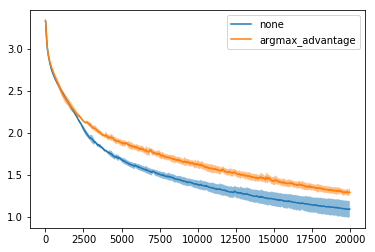

In [337]:
#strategies = ['none', 'sequence', 'element', 'argmax_advantage']
strategies = ['none', 'argmax_advantage']
for strategy in strategies:
    plt.plot(train_losses_av_mean[strategy])
    plt.fill_between(
        range(num_steps),
        train_losses_av_mean[strategy] - train_losses_av_std[strategy],
        train_losses_av_mean[strategy] + train_losses_av_std[strategy],
        alpha=0.5
    )
plt.legend(strategies)
#for strategy in strategies:
#    plt.plot(train_losses_pav_av_mean[strategy], '--')

In [279]:
av_advantage =  np.array(av_advantage)

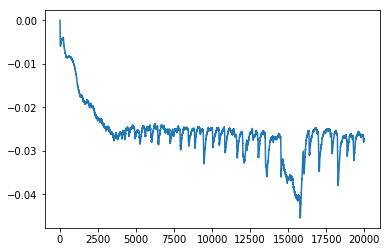

In [342]:
plt.plot(running_average(list(np.min(av_advantage_argmax, axis=1))))

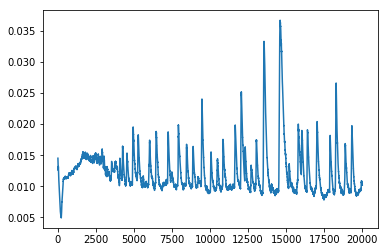

In [343]:
plt.plot(running_average(list(np.max(av_advantage_argmax, axis=1))))

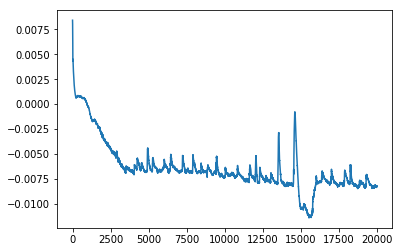

In [344]:
plt.plot(running_average(list(np.mean(av_advantage_argmax, axis=1))))

In [283]:
std_advantage =  np.array(std_advantage)

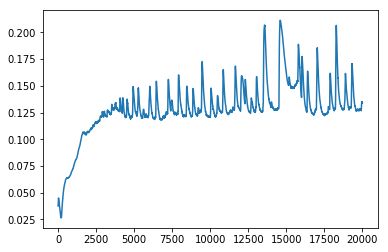

In [347]:
plt.plot(running_average(list(np.mean(std_advantage_argmax, axis=1))))

In [327]:
grad_norms = np.array(grad_norms)

In [287]:
grad_norms.shape

(10000, 15)

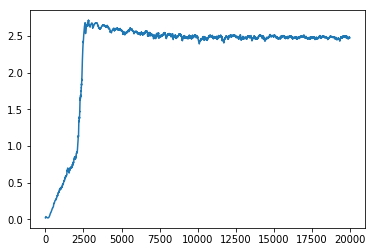

In [349]:
plt.plot(running_average(list(grad_norms_none[:, 10])))
#plt.plot(running_average(list(grad_norms_argmax[:, 10])))
#plt.legend(['none', 'argmax_advantage'])

In [328]:
av_advantage_argmax = np.copy(av_advantage)
std_advantage_argmax = np.copy(std_advantage)
grad_norms_argmax = np.copy(grad_norms)

In [338]:
grad_norms_none = np.copy(grad_norms)